# **Milestone 2, GROUP 12**

## Members: Xiqing Mao, Zelin Li, Lu Wang

*Some settings:*

In [1]:
import psycopg2
from psycopg2.extensions import ISOLATION_LEVEL_AUTOCOMMIT
import pandas as pd
from IPython.display import HTML, Math
display(HTML("<script src='https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default'></script>"))

In [2]:
'''
# setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
# setup a database with name `m2` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS m2;'
!sudo -u postgres psql -U postgres -c 'CREATE DATABASE m2;'
'''

'\n# setup a password `postgres` for username `postgres`\n!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD \'postgres\';"\n# setup a database with name `m2` to be used\n!sudo -u postgres psql -U postgres -c \'DROP DATABASE IF EXISTS m2;\'\n!sudo -u postgres psql -U postgres -c \'CREATE DATABASE m2;\'\n'

## Task 0 Load csv file

We loaded entire csv (`1mio-raw.csv`) to table `news`:

```
CREATE TABLE news
(
	index TEXT,id TEXT,domain TEXT,type TEXT,url TEXT,content TEXT,
	scraped_at DATE,inserted_at DATE,updated_at DATE,
	title TEXT,authors TEXT,keywords TEXT,
	meta_keywords TEXT,meta_description TEXT,tags TEXT,summary TEXT,source TEXT
);
```
Attribute such as `ID` shoud be `INTEGER NOT NULL` since we decided to set it as PK for futher use, but we found that there are some empty rows and unexpected strings in it. We therefore set it to `TEXT` firstly and changed it back to `INTEGER NOT NULL` and `INTEGER` after loading.

In [1]:
# Notice that this is using the root(admin) user 'postgres', so the password may not be 'postgres' in your PC, you have to change it.
your_pwd = 'postgres' # Change this to your password

path_input = '/Users/qti/Desktop/1mio-raw.csv' # Change this to your input data file path

# Connect to PostgreSQL
con = psycopg2.connect(user='postgres',password=your_pwd,host="127.0.0.1",port="5432")
con.set_isolation_level(ISOLATION_LEVEL_AUTOCOMMIT)

# Create a cursor object using the cursor() method
cur = con.cursor()

# Setup a password 'postgres' for username 'postgres'(which is root,admin user)
cur.execute("ALTER USER postgres PASSWORD 'postgres';")

# Setup a database with name m2 to be used, removed it if already exsists one
name_Database = 'm2' #define database name
cur.execute("DROP DATABASE IF EXISTS "+name_Database+";")

# Create database statement (Create a database with name as m2)
cur.execute("CREATE DATABASE "+name_Database+";")

con.commit() # Commit all changes
con.close() # Closing the connection
print("Database \'"+name_Database+"\' created successfully!")

Database 'm2' created successfully!


In [2]:
con = psycopg2.connect(database=name_Database,user='postgres',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()

# Create a table called 'news' in the database ('m2' in this case), drop it if it already exsists
name_table = 'news' # Define table name
cur.execute('DROP TABLE IF EXISTS '+name_table+';')
cur.execute("CREATE TABLE "+name_table+"(index TEXT,id TEXT,domain TEXT,type TEXT,url TEXT,content TEXT,scraped_at DATE,inserted_at DATE,updated_at DATE,title TEXT,authors TEXT,keywords TEXT,meta_keywords TEXT,meta_description TEXT,tags TEXT,summary TEXT,source TEXT);")

# Copy data from csv file to pSQL this database m2
cur.execute("COPY "+name_table+" FROM \'"+path_input+"\' DELIMITER ',' CSV HEADER;") # Or CSV HEADER ENCODING 'UTF8';

# Delete news without 'id' attribute
cur.execute('DELETE FROM '+name_table+' WHERE id IS NULL')
# Delete text in 'id' attribute
cur.execute("DELETE FROM "+name_table+" WHERE id ~* '^[a-zA-Z]|\d*\.\d*'")
# Set integer for id
cur.execute("ALTER TABLE "+name_table+" ALTER COLUMN id TYPE integer USING id::integer") 

con.commit()
print("Database \'"+name_Database+"\' table \'"+name_table+"\' successfully filled in data from \'"+path_input+"\'!")

Database 'm3' table 'news' successfully filled in data from '/Users/qti/Desktop/1mio-raw.csv'!


In [5]:
# Count news number
cur.execute('SELECT COUNT(id) FROM '+name_table)
all_news=cur.fetchall()
print(all_news[0][0],'news in total')

# Count distinct news number
cur.execute('SELECT DISTINCT(authors,domain,title,content,meta_description,meta_keywords,tags) FROM '+name_table)
dis_news=cur.fetchall()
print(len(dis_news),'news are distinct')

999934 news in total
904911 news are distinct


In [6]:
# Count each type of news number
cur.execute('SELECT type, COUNT(type) FROM '+name_table+' GROUP BY type ORDER BY type')
count_type = pd.DataFrame(cur.fetchall(), columns=['type', 'original'])

# Remove duplicate news
cur.execute('DELETE FROM '+name_table+' n WHERE n.id = ANY(ARRAY (SELECT id FROM (SELECT row_number() OVER (PARTITION BY authors,domain,title,content,meta_description,meta_keywords,tags), id FROM '+name_table+') t WHERE t.row_number > 1))')

cur.execute('select count(id) from '+name_table)
removed_news=cur.fetchall()
con.commit()
con.close()
print(all_news[0][0]-removed_news[0][0],"duplicates are removed successfully!")

95023 duplicates are removed successfully!


## **Task 1 Schema design**

We have some observations:

1. There are around one million news in dataset, but only 394 distinct doamins and 12 types.

2. One domain only contribuates to one `type` (unique), but one `type` could be corresponding to many domains. One `article` could only have one `type`, but there can be the case for a `type` without a corresponding `article`.

3. One `domain` could have multiple `URL`, while one `URL` is distinct for each `article` in this dataset. Although we have not observed an `URL` corresponding to multiple articles after we removed the duplicates, this still can be happened.

4. Three dates (`scraped_at`,`inserted_at`,`updated_at`) are identical since we use `DATE` rather than `TIMESTAMP`.

5. `summary`,`source`,`keywords` are `NULL` for all row in our dataset.

6. One `author` could write multiple articles, but there can be the case for exist an `author` and we assume he only write fake news, but none of news articles of him have recorded to our database yet, we still can put the author name into our database.

So based on '2.', we separate `type`(attribute) from `article`(table) relations' attributes and designed relations `is_type` and `type`(table) to store the information of `type`(attribute);

Similarly to '2.': based on '3.', we designed relations `from_where`, `URL` and `domain`, based on '6.', we designed `w_by`(written) and `aut`(author) relations.

Based on '4.', we designed relation `date`;

Based on '5.', we remove `source` and `keywords` from the input, but `summary` column is remained (because we assume `keywords` can be replaced by `meta_keywords`, while source can be viewed as a property of domain or URL).

So our shcema is:

![image.png](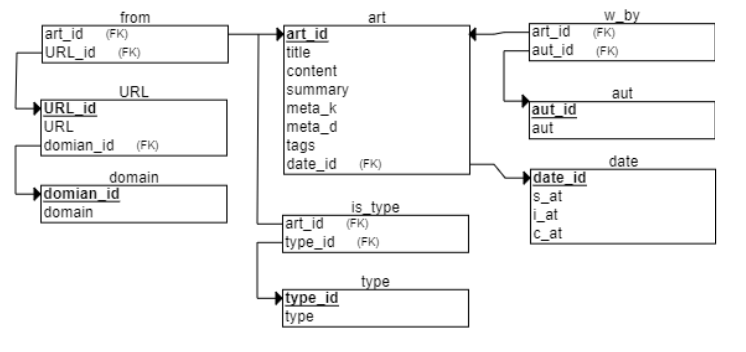
)

In [8]:
# Connect to pSQL
con = psycopg2.connect(database=name_Database,user='postgres',password=your_pwd,host='127.0.0.1',port='5432')
cur = con.cursor()

### **1.1** Creat table `domain`

In [9]:
# create table domain
cur.execute("DROP table IF EXISTS domain")
cur.execute("SELECT id,domain into domain FROM "+name_table+";")
# delete duplicate domains
cur.execute('DELETE FROM domain d WHERE d.id NOT IN (SELECT MIN(id) FROM domain GROUP BY domain)')
# drop id
cur.execute('ALTER TABLE domain DROP COLUMN id')
# generate domain_id
cur.execute('ALTER TABLE domain ADD COLUMN d_id SERIAL UNIQUE')
# set domain as Primary key (PK)
cur.execute('ALTER TABLE domain ADD PRIMARY KEY(d_id)')
con.commit()

### **1.2** Creat table `URL`

In [10]:
# create table URL
cur.execute("DROP table IF EXISTS URL")
cur.execute("SELECT id,URL,domain INTO URL FROM "+name_table+";")
# rename id to url_id
cur.execute('ALTER TABLE URL RENAME COLUMN id TO url_id')
# insert domain_id
cur.execute('ALTER TABLE URL ADD column d_id integer')
cur.execute('UPDATE URL SET d_id = domain.d_id FROM domain WHERE URL.domain=domain.domain')
cur.execute('ALTER TABLE URL DROP COLUMN domain')
# set url_id as PK
cur.execute('ALTER TABLE URL ADD PRIMARY KEY (url_id)')
con.commit()

### **1.3** Creat table `date`

In [11]:
# create table date
cur.execute("DROP TABLE IF EXISTS date")
cur.execute("SELECT id,scraped_at,inserted_at,updated_at INTO date FROM "+name_table+";")
# delete duplicate date
cur.execute('DELETE FROM date d WHERE d.id NOT IN (SELECT MIN(id) FROM date GROUP BY scraped_at,inserted_at,updated_at)')
# add date_id
cur.execute('ALTER TABLE date DROP COLUMN id')
cur.execute('CREATE SEQUENCE date_id')
cur.execute("ALTER TABLE date ADD COLUMN date_id integer NOT NULL DEFAULT NEXTVAL('date_id')")
cur.execute('ALTER SEQUENCE date_id OWNED BY date.date_id')
# set date_id as PK
cur.execute('ALTER TABLE date ADD PRIMARY KEY (date_id)')
con.commit()

### **1.4** Creat table `article`

In [12]:
# create table article
cur.execute("DROP TABLE IF EXISTS article")
cur.execute("SELECT id,title,summary,content,scraped_at,inserted_at,updated_at,meta_keywords,meta_description,tags INTO article FROM "+name_table+";")
# insert date_id
cur.execute('ALTER TABLE article ADD column date_id integer')
cur.execute('UPDATE article SET date_id = date.date_id FROM date WHERE article.scraped_at=date.scraped_at AND article.inserted_at=date.inserted_at AND article.updated_at=date.updated_at')
cur.execute('ALTER TABLE article DROP COLUMN scraped_at, DROP COLUMN inserted_at, DROP COLUMN updated_at')
# set id as PK
cur.execute('ALTER TABLE article ADD PRIMARY KEY (id)')
# set date_id as foreign key (FK)
cur.execute('ALTER TABLE article ADD CONSTRAINT fk_date FOREIGN KEY (date_id) REFERENCES date(date_id)')
con.commit()

### **1.5** Creat table `from_where`

In [13]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS from_where")
cur.execute("SELECT id INTO from_where FROM "+name_table+";")
cur.execute('ALTER TABLE from_where ADD COLUMN url_id integer')
cur.execute('UPDATE from_where SET url_id=id;')
# set FK
cur.execute('ALTER TABLE from_where ADD CONSTRAINT fk_fromurlid FOREIGN KEY (url_id) REFERENCES URL(url_id)')
cur.execute('ALTER TABLE from_where ADD CONSTRAINT fk_fromartid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

### **1.6** Creat table `type`

In [14]:
# create table type
cur.execute("DROP TABLE IF EXISTS type")
cur.execute("SELECT id,type into type from "+name_table+";")
# delete duplicate type
cur.execute('DELETE FROM type t WHERE t.id NOT IN (SELECT MIN(id) FROM type GROUP BY type)')
# add date_id
cur.execute('ALTER TABLE type DROP COLUMN id')
cur.execute('CREATE SEQUENCE type_id')
cur.execute("ALTER TABLE type ADD COLUMN type_id integer NOT NULL DEFAULT NEXTVAL('type_id')")
cur.execute('ALTER SEQUENCE type_id OWNED BY type.type_id')
# set date_id as PK
cur.execute('ALTER TABLE type ADD PRIMARY KEY (type_id)')
con.commit()

### **1.7** Creat table `aut`

In [15]:
# create table aut(author)
cur.execute("DROP TABLE IF EXISTS aut")
cur.execute("SELECT id,authors INTO aut FROM "+name_table+";")
# delete dup authors
cur.execute('DELETE FROM aut a WHERE a.id NOT IN (SELECT MIN(id) FROM aut GROUP BY authors)')
# drop id
cur.execute('ALTER TABLE aut DROP COLUMN id')
# gen aut_id
cur.execute('ALTER TABLE aut add COLUMN aut_id SERIAL UNIQUE')
# set domain as PK
cur.execute('ALTER TABLE aut ADD PRIMARY KEY(aut_id)')
con.commit()

### **1.8** Creat table `w_by`

In [16]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS w_by")
cur.execute("SELECT id,authors INTO w_by FROM "+name_table+";")
# insert aut_id
cur.execute('ALTER TABLE w_by ADD COLUMN aut_id integer')
cur.execute('UPDATE w_by SET aut_id = aut.aut_id FROM aut WHERE aut.authors=w_by.authors')
cur.execute('ALTER TABLE w_by DROP COLUMN authors')
# set FK
cur.execute('ALTER TABLE w_by ADD CONSTRAINT fk_autid FOREIGN KEY (aut_id) REFERENCES aut(aut_id)')
cur.execute('ALTER TABLE w_by ADD CONSTRAINT fk_artautid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

### **1.9** Creat table `is_type`

In [17]:
# create table from_where
cur.execute("DROP TABLE IF EXISTS is_type")
cur.execute("SELECT id,type INTO is_type FROM "+name_table+";")
# insert type_id
cur.execute('ALTER TABLE is_type ADD COLUMN type_id integer')
cur.execute('UPDATE is_type SET type_id=type.type_id FROM type WHERE is_type.type=type.type')
cur.execute('ALTER TABLE is_type DROP COLUMN type')
# set FK
cur.execute('ALTER TABLE is_type ADD CONSTRAINT fk_typeid FOREIGN KEY (type_id) REFERENCES type(type_id)')
cur.execute('ALTER TABLE is_type ADD CONSTRAINT fk_arttypeid FOREIGN KEY (id) REFERENCES article(id)')
con.commit()

## **Task 2 Relations of the database**

List the relations you have created in your database. The attributes, functional dependencies and all primary keys of our database tables are:

### 2.1 domain table

2.1.1 attributes: domain_id, domain

2.1.2 functional dependencies: domain_id->domain

2.1.3 primary keys: domain

### 2.2 URL table

2.2.1 attributes: URL, URL_id, domain_id

2.2.2 functional dependencies: URL_id->URL, URL_id->domain_id

2.2.3 primary keys: URL_id

### 2.3 from_where table

2.3.1 attributes: art_id(id), URL_id

2.3.2 functional dependencies: art_id->URL_id

2.3.3 primary keys: ×

### 2.4 article table

2.4.1 attributes: art_id(id), title, content, summary, meta_k(meta_keywords), meta_d(meta_description), tags, date_id

2.4.2 functional dependencies:

art_id->title

art_id->content

art_id->summary

art_id->meta_k

art_id->meta_d

art_id->tags

art_id->date_id

2.4.3 primary keys: art_id

### 2.5 date table

2.5.1 attributes: date_id, sc_at(scraped_at), ins_at(inserted_at), upd_at(updated_at)

2.5.2 functional dependencies:

date_id->sc_at

date_id->ins_at

date_id->upd_at

2.5.3 primary keys: date_id

### 2.6 'w_by'(written by) table

2.6.1 attributes: art_id, aut_id

2.6.2 functional dependencies: art_id->aut_id

2.6.3 primary keys: ×

### 2.7 aut(author) table

2.7.1 attributes: aut_id, aut

2.7.2 functional dependencies: aut_id->aut

2.7.3 primary keys: aut_id

### 2.8 is_type table

2.8.1 attributes: art_id, type_id

2.8.2 functional dependencies: art_id->type_id

2.8.3 primary keys: ×

### 2.9 type table:

2.9.1 attributes: type_id, type

2.9.2 functional dependencies: type_id->type

2.9.3 primary keys: type_id

### Is each relation in BCNF form? If not, show how to transform the tables in BCNF and explain why it might be better (or not) to use the BCNF relations in your database.

Yes, for now the database is in BCNF form (each relation have only one primary key available), but we don't think this is the best practice for this dataset, since for example: each domain have only one type, so this can be viewed as a functional dependency: domain->type, so if we use domain as a foreign key of table article, and make domain as primary key of domian table which contain attributes domain and type, then we can remove redundancy.




## **Task 3 Query**

**1. List the domains of news articles of reliable type and scraped at or after January 15, 2018. NOTE: Do not include duplicate domains in your answer.** 

Relational algebra:  
$\textbf{π}_{domain\_name}\textbf{σ}_{type=reliable ∧ scraped\_at>=2018-01-25}(domain⋈URL⋈article⋈from\_where⋈types⋈is\_typedate).$  

SQL:
```
SELECT DISTINCT domain 
FROM ((((( domain INNER JOIN URL USING(d_id)
    ) INNER JOIN from_where USING(URL_id)
   ) INNER JOIN article USING(id)
  ) INNER JOIN is_type USING(id)
 ) INNER JOIN type USING (type_id)
) INNER JOIN date USING (date_id)
WHERE type = 'reliable' AND scraped_at>='2018-01-25'
```

In [18]:
cur.execute("SELECT DISTINCT domain FROM (((((domain INNER JOIN URL USING(d_id)) INNER JOIN from_where USING(URL_id)) INNER JOIN article USING(id)) INNER JOIN is_type USING(id)) INNER JOIN type USING (type_id)) INNER JOIN date USING(date_id) WHERE type='reliable' AND scraped_at>='2018-01-25'")
print('The domains of news articles of reliable type and scraped at or after January 15, 2018 are:')
for i in cur.fetchall():
  print(i[0])

The domains of news articles of reliable type and scraped at or after January 15, 2018 are:
nutritionfacts.org
christianpost.com
consortiumnews.com


**2. List the name(s) of the most prolific author(s) of news articles of fake type. An author is among the most prolific if it has authored as many or more fake news articles as any other author in the dataset.**

Relational algebra:   
$\textbf{π}_{MAX(mycount)→max\_aut}\textbf{σ}(\textbf{π}_{mycount}(\textbf{γ}_{authors,COUNT(authors)→mycount}(\textbf{σ}_{type=fake}(aut⋈w\_by⋈article⋈is\_type⋈types)))),$ 
$\textbf{π}_{authors}(\textbf{σ}_{COUNT(authors)=max\_aut}(\textbf{γ}_{authors}(\textbf{σ}_{type=fake}(aut⋈w\_by⋈article⋈is\_type⋈types)))).$ 

SQL:
```
SELECT authors 
FROM ((aut INNER JOIN w_by USING(aut_id))
  INNER JOIN article USING(id)
  INNER JOIN is_type USING(id)
) INNER JOIN type USING(type_id)
WHERE type = 'fake' 
GROUP BY authors
HAVING COUNT(authors)=(
  SELECT COUNT(authors) A mycount 
  FROM ((aut INNER JOIN w_by USING(aut_id))
    INNER JOIN article USING(id)
    INNER JOIN is_type USING(id)
  ) INNER JOIN type USING(type_id)
  WHERE type = 'fake' 
  GROUP BY authors 
  ORDER BY mycount desc limit 1
)
```

In [19]:
cur.execute("SELECT authors FROM ((aut INNER JOIN w_by USING(aut_id)) INNER JOIN article USING(id) INNER JOIN is_type USING(id)) INNER JOIN type USING(type_id) WHERE type = 'fake' GROUP BY authors HAVING COUNT(authors)=(SELECT COUNT(authors) AS mycount FROM ((aut INNER JOIN w_by USING(aut_id)) INNER JOIN article USING(id) INNER JOIN is_type USING(id)) INNER JOIN type USING(type_id) WHERE type = 'fake' GROUP BY authors ORDER BY mycount desc limit 1)")
print('The most prolific author of news articles of fake type is:',cur.fetchall()[0][0])

The most prolific author of news articles of fake type is: John Rolls




**3. Count the pairs of article IDs that exhibit the exact same set of meta-keywords, but only return the pairs where the set of meta-keywords is not empty.** 

Relational algebra:  
$\textbf{π}_{article1,article2,article1.meta\_keywords}\textbf{γ}_{article1,article2,article1.meta\_keywords}(\textbf{σ}_{char\_length(article1.meta\_keywords)>4  ∧  char\_length(article2.meta\_keywords)>4}(article1×article2)).$  


SQL:
```
SELECT a1.id, a2.id, a1.meta_keywords  
FROM article a1  
JOIN article a2  
ON a1.meta_keywords = a2.meta_keywords AND a1.id != a2.id   
WHERE char_length(a1.meta_keywords)>4 AND char_length(a2.meta_keywords)>4  
GROUP BY a1.id, a2.id, a1.meta_keywords  
LIMIT 100
```
or:
```
SELECT a1.id, a2.id, a1.meta_keywords  
FROM article a1, article a2   
WHERE a1.meta_keywords = a2.meta_keywords AND a1.id != a2.id AND char_length(a1.meta_keywords)>4 AND char_length(a2.meta_keywords)>4  
GROUP BY a1.id, a2.id, a1.meta_keywords  
LIMIT 100
```
Since there are too many results, we only print first 100 pairs.

In [20]:
cur.execute("SELECT a1.id, a2.id, a1.meta_keywords FROM article a1 JOIN article a2 ON a1.meta_keywords = a2.meta_keywords AND a1.id != a2.id AND char_length(a1.meta_keywords)>4 AND char_length(a2.meta_keywords)>4 GROUP BY a1.id, a2.id, a1.meta_keywords LIMIT 100")
pairs = pd.DataFrame(cur.fetchall(), columns=['id 1', 'id 2','meta_keywords'])
pairs

,id 1,id 2,meta_keywords
0,19,813075,"['planned parenthood', 'minorities', 'black cu..."
1,19,813090,"['planned parenthood', 'minorities', 'black cu..."
2,19,813091,"['planned parenthood', 'minorities', 'black cu..."
3,19,813092,"['planned parenthood', 'minorities', 'black cu..."
4,19,813093,"['planned parenthood', 'minorities', 'black cu..."
...,...,...,...
95,109,5146,"['Conservative News', 'Conservative Newspaper']"
96,109,5147,"['Conservative News', 'Conservative Newspaper']"
97,109,5148,"['Conservative News', 'Conservative Newspaper']"
98,109,5149,"['Conservative News', 'Conservative Newspaper']"


## **Task 4 Observations**

Now that we have our data in a database, let’s revisit the “interesting observations” task from Milestone 1 - but now using queries to the database. The idea is to write database queries (e.g. using GROUP BY and COUNT) that explore features of the data set that are relevant to the fake news prediction task: outliers, artefacts. It’s OK to investigate the same issues as in Milestone 1 (now using database queries) - but you are also very welcome to come up with completely new queries. You should write at least 3 such queries.

### 1. `scraped_at,inserted_at,updated_at` are highly redundant, even they are identical for each news.

In [21]:
cur.execute('SELECT DISTINCT scraped_at, inserted_at, updated_at FROM date')
pd.DataFrame(cur.fetchall(), columns=['scraped_at','inserted_at','updated_at'])

,scraped_at,inserted_at,updated_at
0,2018-01-25,2018-02-02,2018-02-02


### 2. A domain only contribute to one type of news.

In [22]:
cur.execute('SELECT distinct domain, count(distinct type) FROM (((aut INNER JOIN w_by USING(aut_id)) INNER JOIN article USING(id)) INNER JOIN is_type USING(id)) INNER JOIN types USING(type_id) group by domain having count( distinct type)>1 order by domain')
print('Table of domain and count (>1) of type (this should have no records):')
pd.DataFrame(cur.fetchall(), columns=['domain','count_of_type'])

Table of domain and count (>1) of type (this should have no records):


,domain,count_of_type


### 3. The length of most news below 5000. Most of extremely large news (>18000) are `fake` news.

In [23]:
# Using the main table ('news') to check word count, first have to split the content to tokens
cur.execute("SELECT type, array_length(regexp_split_to_array(content,'\s'),1) FROM "+name_table+" GROUP BY type, array_length(regexp_split_to_array(content,'\s'),1) ORDER BY array_length(regexp_split_to_array(content,'\s'),1) DESC") 
word_count = pd.DataFrame(cur.fetchall(), columns=['type','word_count'])

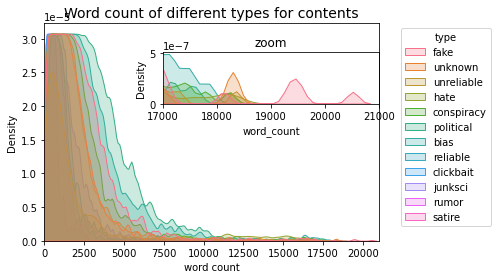

In [24]:
# Show each type contents' word count
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
fig, ax = plt.subplots()
sns.kdeplot(data = word_count, x="word_count", hue = 'type',bw_adjust=0.25, fill=True, ax=ax)
ax.set_title('Word count of different types for contents', fontsize = 14)
ax.set_xlabel('word count')
ax.set_xlim([0,21000])
ax.legend_.set_bbox_to_anchor((1.05, 1))
ax.legend_._set_loc(2)
ax2 = plt.axes([0.4, 0.6, .5, .18], facecolor='w')
sns.kdeplot(data = word_count, x="word_count", hue = 'type', bw_adjust=.25, fill=True, ax=ax2)
ax2.set_title('zoom')
ax2.set_xlim([17000,21000])
ax2.set_ylim([0,0.051e-5])
ax2.get_legend().remove()

### 4.1. Wordcloud for type `fake` 

In [25]:
# count words frequency of type 'fake' articles
cur.execute("SELECT * FROM ts_stat('SELECT to_tsvector(''english'',content) FROM "+name_table+" WHERE type = ''fake''') ORDER BY nentry DESC LIMIT 100") 
fake_freq = pd.DataFrame(cur.fetchall(), columns=['word','occ_num_news','freq'])

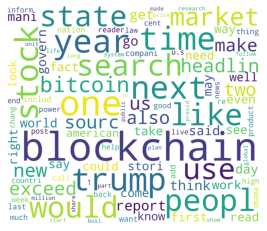

In [26]:
# Use wordclound to show the content tokens
fake_freq_dict = dict(zip(fake_freq['word'].tolist(), fake_freq['freq'].tolist()))
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate_from_frequencies(fake_freq_dict)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 4.2 Wordcloud for type `reliable`

In [27]:
# count words frequency of type 'reliable' articles
cur.execute("SELECT * FROM ts_stat('SELECT to_tsvector(''english'',content) from "+name_table+" where type = ''reliable''') ORDER BY nentry DESC limit 100") 
reliable_freq = pd.DataFrame(cur.fetchall(), columns=['word','occ_num_news','freq'])

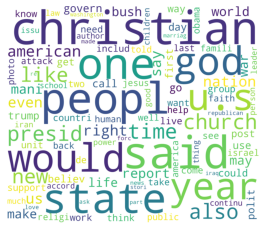

In [28]:
# Use wordclound to show the content tokens
reliable_freq_dict = dict(zip(reliable_freq['word'].tolist(), reliable_freq['freq'].tolist()))
wordcloud = WordCloud(background_color="white",width=2000, height=1720, margin=2).generate_from_frequencies(reliable_freq_dict)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 5. In M1 we believe that 'duplicate news' is a feature of fake news, but now it seems not true. Type `reliable` has much more duplicate news (17.94%) compared with type `fake` (1.74%).

In [7]:
# Below is the type counts of news originally loaded and after duplicates removed.
# Count each type of news number after duplicate news are removed
cur.execute('SELECT type, COUNT(type) FROM '+name_table+' GROUP BY type ORDER BY type')
count_after = pd.DataFrame(cur.fetchall(), columns=['type', 'after_removed'])
count_type['after_removed'] = count_after[['after_removed']]
count_type['removed'] = count_type.apply(lambda x: x['original'] - x['after_removed'], axis=1)
count_type=count_type.drop(index=12)
count_type['removed %'] = count_type.apply(lambda x: 100*x['removed']/x['original'], axis=1)
count_type

,type,original,after_removed,removed,removed %
0,bias,136381,124074,12307,9.023984
1,clickbait,21723,20917,806,3.710353
2,conspiracy,109793,76658,33135,30.179520
3,fake,123929,121772,2157,1.740513
4,hate,3619,3567,52,1.436861
5,junksci,17408,15029,2379,13.666131
6,political,289666,258215,31451,10.857677
7,reliable,6601,5417,1184,17.936676
8,rumor,46524,46466,58,0.124667
9,satire,14263,14252,11,0.077123


In [30]:
con.close()